# Neural Network Code

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data
hitsData = Train5[['SP', 'AB', 'PA', 'Hits', 'BB', 'RA', 'wOBA', 'Outs5', "Outs"]]

hitsData.loc[:,"Outs"] = Train3["Outs"]

# Split the data
X = hitsData.drop(columns=["Outs"])
y = hitsData["Outs"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define the model
input_layer = Input(shape=(8,))  # Adjusted to match the number of features
x = Dense(units=160, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(units=32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(units=32, activation='relu', kernel_regularizer=l2(0.01))(x)
output_layer = Dense(units=1)(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model
y_pred = model.predict(X_test).flatten()
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

In [ ]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers

def build_model(hp):
    input_layer = keras.Input(shape=(8,))
    x = layers.Dense(
        units=hp.Int('units_1', min_value=32, max_value=256, step=32),
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(hp.Float('l2_1', min_value=1e-4, max_value=1e-2, sampling='log'))
    )(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1))(x)
    
    x = layers.Dense(
        units=hp.Int('units_2', min_value=16, max_value=128, step=16),
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(hp.Float('l2_2', min_value=1e-4, max_value=1e-2, sampling='log'))
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1))(x)
    
    output_layer = layers.Dense(1)(x)
    
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        ),
        loss='mean_squared_error'
    )
    
    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='keras_tuner_project'
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_1')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate'):.4f}.
""")

best_model = build_model(best_hps)

# Evaluate the best model
y_pred = best_model.predict(X_test).flatten()
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

In [ ]:
# Print all hyperparameters
print("Best Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

# Print model summary
print("\nBest Model Summary:")
best_model.summary()

In [ ]:
NNpred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
NNpred["Residuals"] = NNpred.Actual - NNpred.Predicted
#NNpred.sort_values(by=['Residuals'], ascending=False)
NNpred

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(8, 6))

# Scatter plot
scatter = plt.scatter(NNpred['Actual'], NNpred['Predicted'], 
                      #=NNpred['Outs'], cmap='viridis', 
                      alpha=0.6, s=50)

# Add color bar
cbar = plt.colorbar(scatter)
#cbar.set_label('Outs', rotation=270, labelpad=15)

# Add reference line
min_val = min(NNpred['Actual'].min(), NNpred['Predicted'].min())
max_val = max(NNpred['Actual'].max(), NNpred['Predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

# Labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
#plt.title('Actual vs Predicted Values (Color: Outs)')

# Add text for R-squared
r_squared = 1 - (NNpred['Residuals']**2).sum() / ((NNpred['Actual'] - NNpred['Actual'].mean())**2).sum()
plt.text(0.05, 0.95, f'R-squared: {r_squared:.4f}', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# Lasso Regression

In [ ]:
Train4 = Train3.copy()

# Identify numeric columns
numeric_columnsTrain = Train4.select_dtypes(include=['float64', 'int64']).columns

# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform numeric columns
Train4[numeric_columnsTrain] = scaler.fit_transform(Train4[numeric_columnsTrain])

# Assuming Train3 is your DataFrame
Train5 = Train4.copy()

# Dictionary to store the label encoders
label_encoders = {}

# Encode non-numeric columns in Train5
non_numeric_columns = Train5.select_dtypes(exclude=['float64', 'int64']).columns
for col in non_numeric_columns:
    label_encoder = LabelEncoder()
    Train5[col] = label_encoder.fit_transform(Train5[col])
    label_encoders[col] = label_encoder

In [ ]:
# Perform Lasso regression with cross-validation
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train, y_train)

# Get the optimal alpha
optimal_alpha = lasso_cv.alpha_
print(f"Optimal alpha: {optimal_alpha:.4f}")

# Train the final model with the optimal alpha
lasso_final = LassoCV(cv=5, alphas=[optimal_alpha])
lasso_final.fit(X_train, y_train)

# Make predictions
y_pred = lasso_final.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

# Get selected features
feature_importance = pd.Series(lasso_final.coef_, index=X.columns)
selected_features = feature_importance[feature_importance != 0].index.tolist()

print("\nSelected features:")
print(selected_features)

# Print feature importance
print("\nFeature Importance:")
for feature, importance in feature_importance[feature_importance != 0].sort_values(key=abs, ascending=False).items():
    print(f"{feature}: {importance:.4f}")
    
len(selected_features)

# VIF

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

X = X  # Replace with your feature names
vif_results = calculate_vif(X)
print(vif_results)

NameError: name 'X' is not defined

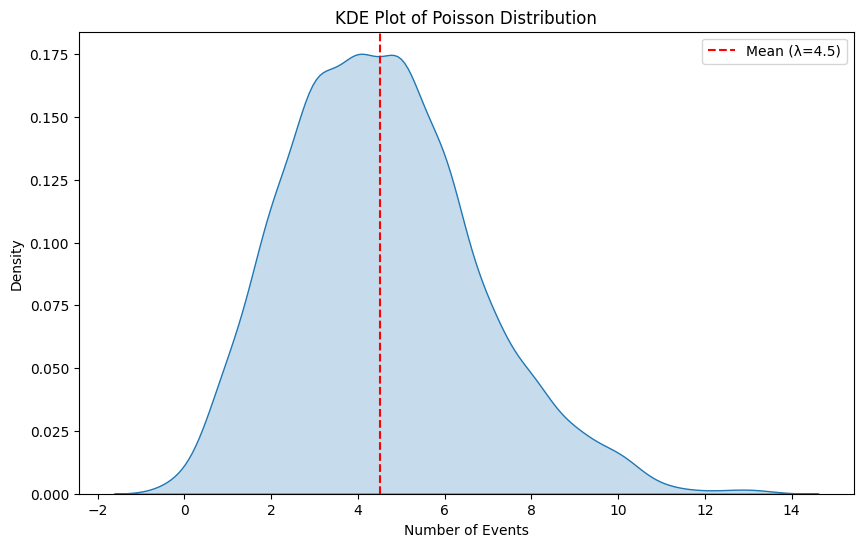

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
import seaborn as sns

# Set the Poisson distribution parameter (mean)
lam = 4.5

# Generate Poisson-distributed data
data = np.random.poisson(lam, size=1000)

# Create the KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data, fill=True)

# Add a vertical line at the mean
plt.axvline(lam, color='r', linestyle='--', label=f'Mean (λ={lam})')

# Customize the plot
plt.title('KDE Plot of Poisson Distribution')
plt.xlabel('Number of Events')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()